# **Implement a small Arabic Skip-gram model**
**of the 200 most frequent words in a training Arabic corpus (Saudi newspaper corpus 21-07-2015.zip) with a window size of 2 and a d-dimension of 100.**

In [1]:
!pip install arabic_reshaper
!pip install python-bidi

In [2]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import re
import arabic_reshaper
from bidi.algorithm import get_display

In [3]:
def get_file_data(stop_word_removal='no'):
    file_contents = []
    with open('/content/drive/My Drive/Freelance/alwesam skipgram/data3.txt') as f: #EX jef_archer.txt
        file_contents = f.read()
    text = []
    for val in file_contents.split('.'):
        #sent = re.findall("[A-Za-z]+", val)
        sent = re.findall(r'[\u0600-\u06FF]+', val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
    return text

In [4]:
def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

In [5]:
def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    #If target_word = best, the index according to the dictionary word_to_index is 0. 
    #So the one hot vector will be [1, 0, 0, 0, 0, 0, 0, 0, 0]
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

In [6]:
#Note : Below comments for trgt_word_index, ctxt_word_index are with the above sample text for understanding the code flow

def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words


In [7]:
def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    #target_word_vector = x , weight_inp_hidden =  weights for input layer to hidden layer  
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    
    #weight_hidden_output = weights for hidden layer to output layer
    u = np.dot(weight_hidden_output.T, hidden_layer)
    
    y_predicted = softmax(u)
    
    return y_predicted, hidden_layer, u
  
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [8]:
def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)
    
    # Update weights
    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

In [9]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

In [10]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

In [11]:
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'no',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    
    
    #For analysis purposes
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, u = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output ,total_error, hidden_layer, target,learning_rate
            )

            loss_temp = calculate_loss(u,context)
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

In [12]:
# Input vector, returns nearest word(s)
def cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    #Get the index of the word from the dictionary
    index = word_to_index[word]
    
    #Get the correspondin weights for the word
    word_vector_1 = weight[index]
    
    
    word_similarity = {}

    for i in range(vocab_size):
        
        word_vector_2 = weight[i]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[i]
        word_similarity[word] = theta
    
    return word_similarity #words_sorted

In [13]:
def print_similar_words(top_n_words,weight,msg,words_subset):
    
    columns=[]
    
    for i in range(0,len(words_subset)):
        columns.append('similar:' +str(i+1) )
        
    df = pd.DataFrame(columns=columns,index=words_subset)
    df.head()
    
    row = 0
    for word in words_subset:
        
        #Get the similarity matrix for the word: word
        similarity_matrix = cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word)
        col = 0
        
        #Sort the top_n_words
        words_sorted = dict(sorted(similarity_matrix.items(), key=lambda x: x[1], reverse=True)[1:top_n_words+1])
        
        #Create a dataframe to display the similarity matrix
        for similar_word,similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word,round(similarity_value,2))
            col += 1
        row += 1
    styles = [dict(selector='caption', 
    props=[('text-align', 'center'),('font-size', '20px'),('color', 'red')])] 
    df = df.style.set_properties(**
                       {'color': 'green','border-color': 'blue','font-size':'14px'}
                      ).set_table_styles(styles).set_caption(msg)
    return df

In [14]:
def plot_epoch_loss(lbl,loss_epoch,plot_title,path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k',dpi=80)
    plt.suptitle('Epoch vs Loss',fontsize=16)
    
    for key,loss in loss_epoch.items():
        
        
        epoch_count = range(1, len(loss) + 1)

        plt.plot(epoch_count, loss, 'r-',color=colors[i],linewidth=2.0,label = lbl + str(key))

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        i += 1

    plt.legend(framealpha=1, frameon=True,fontsize='large',edgecolor="inherit",shadow=True)
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show()
    plt.close()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
path_to_save = '/content/drive/My Drive/Freelance/alwesam skipgram/'
path_to_save_scatter_plot = '/content/drive/My Drive/Freelance/alwesam skipgram/'

In [17]:
def word_similarity_scatter_plot_bigger_corpus(index_to_word,weight,plot_title,path):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    x = x[0:200] #200 most frequent words
    y = y[0:200] #200 most frequent words
    
    plt.figure(figsize=(20, 30)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(get_display(arabic_reshaper.reshape(labels[i])),
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',#family='fantasy'
                     )
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show() ######################################
    plt.close()

    print (labels)
    print (len(labels))

In [18]:
epochs = 50 #200
top_n_words = 5
dimension = 20 #100
window_size = 2
learning_rate = 0.01

In [19]:
text = get_file_data()
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)
words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)

Number of unique words: 1169
Length of corpus : 1778


In [ ]:
len(text)

78

Epoch: 0. Loss:57432.95018503965
Epoch: 49. Loss:27183.49780700734


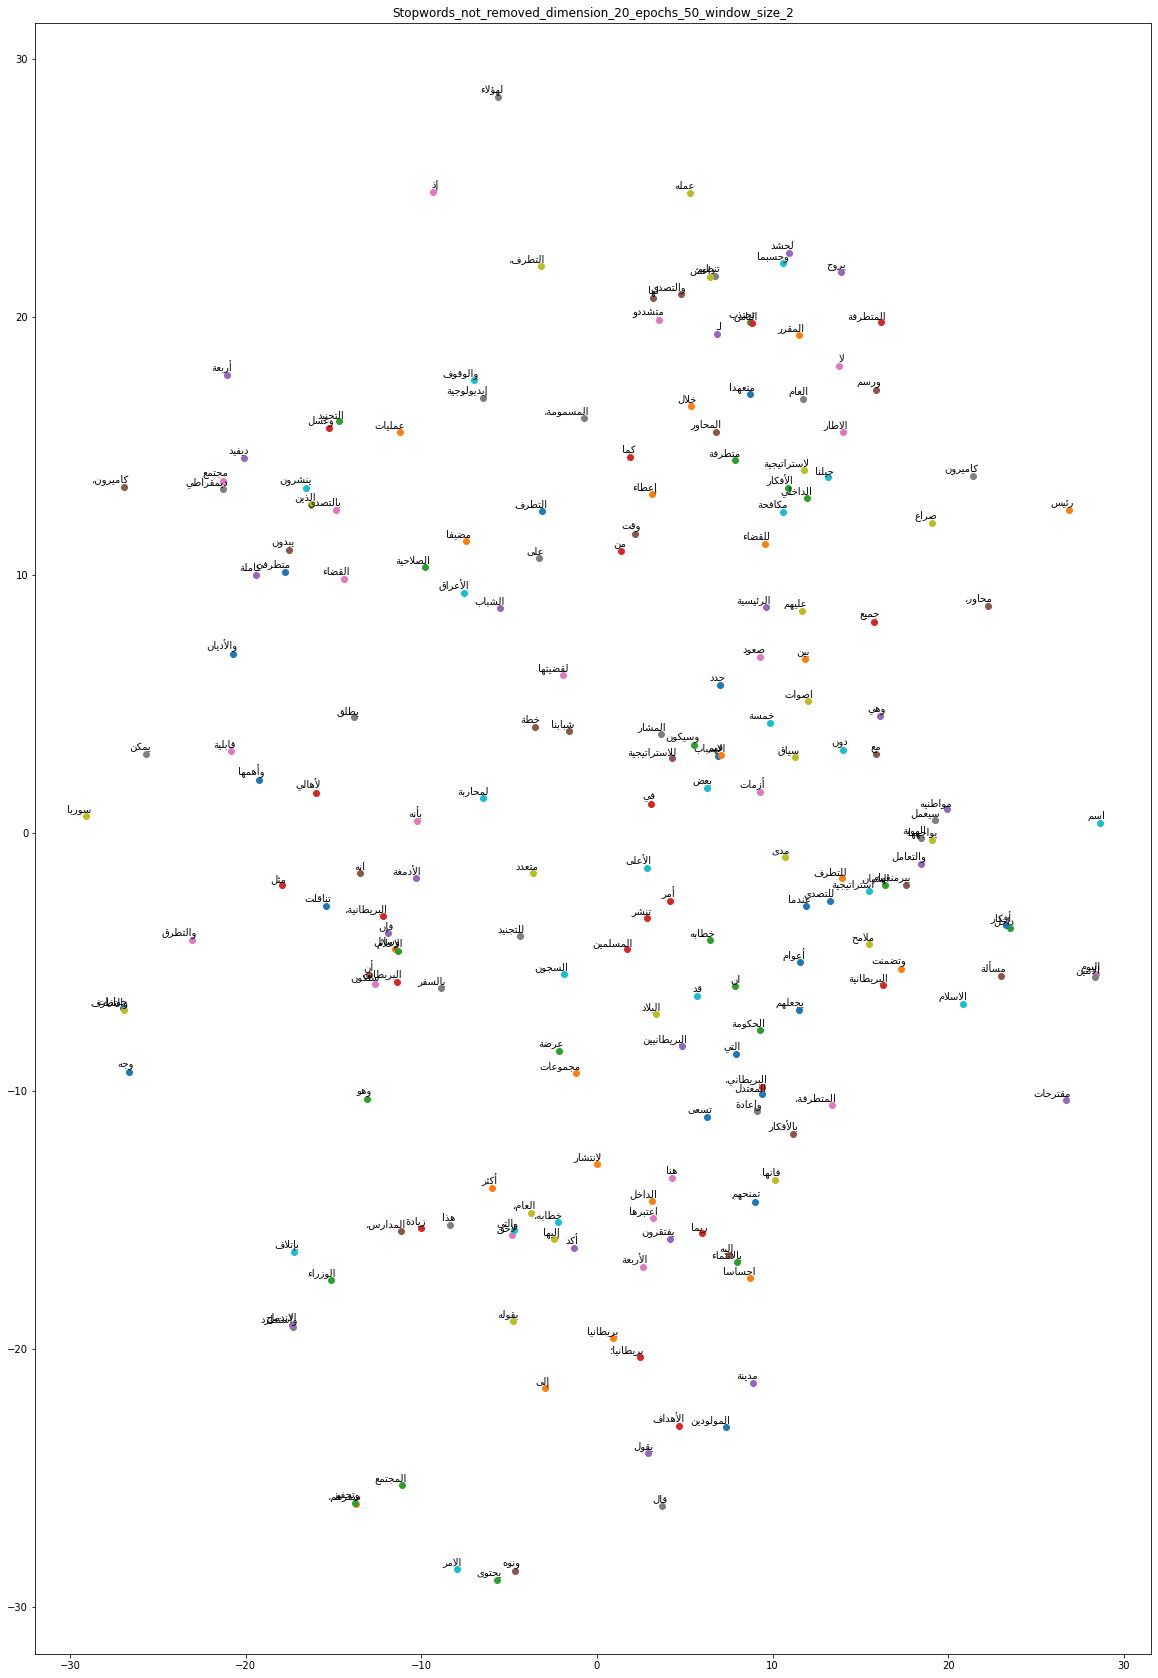

['حدد', 'رئيس', 'الوزراء', 'البريطاني', 'ديفيد', 'كاميرون،', 'اليوم', 'الاثنين', 'ملامح', 'استراتيجية', 'للتصدي', 'للتطرف', 'داخل', 'بريطانيا؛', 'وهي', 'مسألة', 'اعتبرها', 'كاميرون', 'صراع', 'جيلنا', 'متعهدا', 'خلال', 'خطابه', 'في', 'مدينة', 'بيرمنغهام', 'بالتصدي', 'لهؤلاء', 'الذين', 'ينشرون', 'التطرف', 'بين', 'الشبان', 'المسلمين', 'البريطانيين', 'ورسم', 'الاطار', 'العام', 'لاستراتيجية', 'مكافحة', 'التي', 'المقرر', 'ان', 'تنشر', 'كاملة', 'وقت', 'لاحق', 'هذا', 'العام،', 'والتي', 'تسعى', 'لانتشار', 'الأفكار', 'المتطرفة', 'يروج', 'لها', 'متشددو', 'تنظيم', 'داعش', 'وحسبما', 'تناقلت', 'وسائل', 'الإعلام', 'البريطانية،', 'فإن', 'خطة', 'ستكون', 'على', 'مدى', 'خمسة', 'أعوام', 'للقضاء', 'الداخلي', 'من', 'أربعة', 'محاور،', 'القضاء', 'إيديولوجية', 'التطرف،', 'والوقوف', 'وجه', 'عمليات', 'التجنيد', 'وغسل', 'الأدمغة', 'بالأفكار', 'المتطرفة،', 'وإعادة', 'اصوات', 'الاسلام', 'المعتدل', 'إلى', 'المجتمع', 'البريطاني،', 'والتعامل', 'مع', 'أزمات', 'الهوية', 'يواجهها', 'بعض', 'المولودين', 'بريطانيا', 'وسيكون

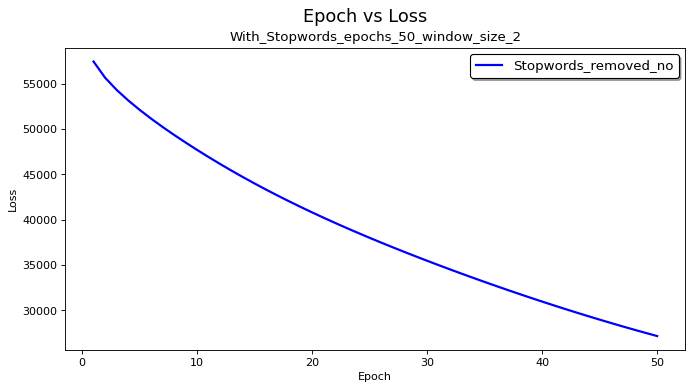

In [20]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

loss_epoch = {}
dataframe_sim = []

epoch_loss,weights_1,weights_2 = train(dimension,window_size,epochs,training_data,learning_rate,'yes',50)
loss_epoch.update( {'no': epoch_loss} )


word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'Stopwords_not_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save_scatter_plot
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : Stopwords_not_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size), words_subset)
dataframe_sim.append(df)
plot_epoch_loss(
    'Stopwords_removed_',
    loss_epoch,
    'With_Stopwords_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)